In [1]:
import os
import cv2
import numpy as np
import glob
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


Breaking down data

Labels in the mask are :  [  0 255]
Labels are:  [0]  and the counts are:  [11943]


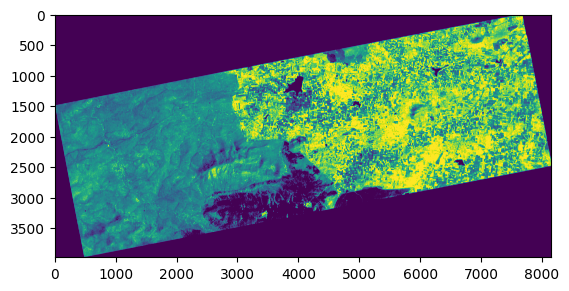

In [2]:
temp_img = cv2.imread("data/images/813.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread("data/masks/813_mask.tif") #3 channels but all same.
arr=np.array(temp_mask)
print("Labels in the mask are : ", np.unique(temp_mask))
labels, count = np.unique(temp_mask[:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

In [3]:
arr

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Declaring the root directory and patch size

In [4]:
root_directory = 'data/'
patch_size = 256

Reading the image directory and dividing into patches



In [5]:
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    # Create the output directory for patches if it doesn't exist
    output_dir = os.path.join(root_directory, "256_patches", "images")
    os.makedirs(output_dir, exist_ok=True)

    dirname = path.split(os.path.sep)[-1]
    images = os.listdir(path)
    for i, image_name in enumerate(images):
        if image_name.endswith(".tif"):
            image = cv2.imread(os.path.join(path, image_name), 1)
            SIZE_X = (image.shape[1] // patch_size) * patch_size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            patches_img = patchify(image, (256, 256, 3), step=256)

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, :, :]
                    single_patch_img = single_patch_img[0]

                    patch_filename = f"{image_name}_patch_{i}{j}.tif"
                    patch_path = os.path.join(output_dir, patch_filename)
                    cv2.imwrite(patch_path, single_patch_img)
            
  

Reading the masks directory and dividing into patches

In [6]:
mask_dir = os.path.join(root_directory, "masks")
output_dir = os.path.join(root_directory, "256_patches", "masks")
os.makedirs(output_dir, exist_ok=True)

for path, subdirs, files in os.walk(mask_dir):
    dirname = path.split(os.path.sep)[-1]
    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):
        if mask_name.endswith(".tif"):
            mask = cv2.imread(os.path.join(path, mask_name))
            SIZE_X = (mask.shape[1] // patch_size) * patch_size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)

            patches_mask = patchify(mask, (256, 256,3), step=256)

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i, j, :, :]
                    single_patch_mask = single_patch_mask[0]

                    patch_filename = f"{mask_name}_patch_{i}{j}.tif"
                    patch_path = os.path.join(output_dir, patch_filename)
                    cv2.imwrite(patch_path, single_patch_mask)


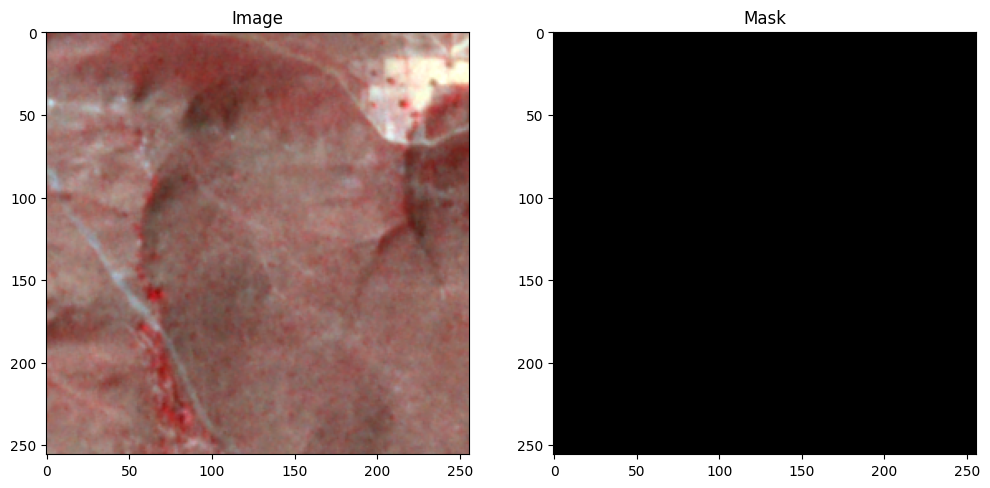

In [7]:
train_img_dir = "data/256_patches/images/"
train_mask_dir = "data/256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

Fetching the useful pixels only

In [8]:
useless=0  #Useless image counter
useful_path="data/256_patches"
mask_dir = os.path.join(useful_path, "images_with_useful_info")
output_dir = os.path.join(useful_path, "images_with_useful_info", "masks")
os.makedirs(output_dir, exist_ok=True)

img_dir = os.path.join(useful_path, "images_with_useful_info")
output_dir = os.path.join(useful_path, "images_with_useful_info", "images")
os.makedirs(output_dir, exist_ok=True)
for img in range(len(img_list)):   #Using t1_list as all lists are? of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
#         print("Save Me")
        cv2.imwrite('data/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('data/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
        
    else:
#         print("I am useless")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,57

Now preparing image and masks number:  0
Now preparing image and masks number:  1
Now preparing image and masks number:  2
Now preparing image and masks number:  3
Now preparing image and masks number:  4
Now preparing image and masks number:  5
Now preparing image and masks number:  6
Now preparing image and masks number:  7
Now preparing image and masks number:  8
Now preparing image and masks number:  9
Now preparing image and masks number:  10
Now preparing image and masks number:  11
Now preparing image and masks number:  12
Now preparing image and masks number:  13
Now preparing image and masks number:  14
Now preparing image and masks number:  15
Now preparing image and masks number:  16
Now preparing image and masks number:  17
Now preparing image and masks number:  18
Now preparing image and masks number:  19
Now preparing image and masks number:  20
Now preparing image and masks number:  21
Now preparing image and masks number:  22
Now preparing image and masks number:  23
No

Now preparing image and masks number:  206
Now preparing image and masks number:  207
Now preparing image and masks number:  208
Now preparing image and masks number:  209
Now preparing image and masks number:  210
Now preparing image and masks number:  211
Now preparing image and masks number:  212
Now preparing image and masks number:  213
Now preparing image and masks number:  214
Now preparing image and masks number:  215
Now preparing image and masks number:  216
Now preparing image and masks number:  217
Now preparing image and masks number:  218
Now preparing image and masks number:  219
Now preparing image and masks number:  220
Now preparing image and masks number:  221
Now preparing image and masks number:  222
Now preparing image and masks number:  223
Now preparing image and masks number:  224
Now preparing image and masks number:  225
Now preparing image and masks number:  226
Now preparing image and masks number:  227
Now preparing image and masks number:  228
Now prepari

Now preparing image and masks number:  401
Now preparing image and masks number:  402
Now preparing image and masks number:  403
Now preparing image and masks number:  404
Now preparing image and masks number:  405
Now preparing image and masks number:  406
Now preparing image and masks number:  407
Now preparing image and masks number:  408
Now preparing image and masks number:  409
Now preparing image and masks number:  410
Now preparing image and masks number:  411
Now preparing image and masks number:  412
Now preparing image and masks number:  413
Now preparing image and masks number:  414
Now preparing image and masks number:  415
Now preparing image and masks number:  416
Now preparing image and masks number:  417
Now preparing image and masks number:  418
Now preparing image and masks number:  419
Now preparing image and masks number:  420
Now preparing image and masks number:  421
Now preparing image and masks number:  422
Now preparing image and masks number:  423
Now prepari

Now preparing image and masks number:  634
Now preparing image and masks number:  635
Now preparing image and masks number:  636
Now preparing image and masks number:  637
Now preparing image and masks number:  638
Now preparing image and masks number:  639
Now preparing image and masks number:  640
Now preparing image and masks number:  641
Now preparing image and masks number:  642
Now preparing image and masks number:  643
Now preparing image and masks number:  644
Now preparing image and masks number:  645
Now preparing image and masks number:  646
Now preparing image and masks number:  647
Now preparing image and masks number:  648
Now preparing image and masks number:  649
Now preparing image and masks number:  650
Now preparing image and masks number:  651
Now preparing image and masks number:  652
Now preparing image and masks number:  653
Now preparing image and masks number:  654
Now preparing image and masks number:  655
Now preparing image and masks number:  656
Now prepari

Now preparing image and masks number:  845
Now preparing image and masks number:  846
Now preparing image and masks number:  847
Now preparing image and masks number:  848
Now preparing image and masks number:  849
Now preparing image and masks number:  850
Now preparing image and masks number:  851
Now preparing image and masks number:  852
Now preparing image and masks number:  853
Now preparing image and masks number:  854
Now preparing image and masks number:  855
Now preparing image and masks number:  856
Now preparing image and masks number:  857
Now preparing image and masks number:  858
Now preparing image and masks number:  859
Now preparing image and masks number:  860
Now preparing image and masks number:  861
Now preparing image and masks number:  862
Now preparing image and masks number:  863
Now preparing image and masks number:  864
Now preparing image and masks number:  865
Now preparing image and masks number:  866
Now preparing image and masks number:  867
Now prepari

Divide data into training and testing data.

In [9]:
import splitfolders  # or import split_folders

input_folder = 'data/256_patches/images_with_useful_info/'
output_folder = 'data/data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 188 files [00:00, 208.36 files/s]
